In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder, rotation_feature_engineer, accelrometer_feature_engineer
from src.data_cleaning import clean_df, normalize_sequence_count
from src.utils.model_utils import evaluate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.utils.math_utils import remove_gravity
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [3]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_2_v26,tof_3_v17,tof_4_v5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,122.0,57.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,124.0,68.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,133.0,97.0,107.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,151.0,113.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,207.0,121.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,62.0,219.0,93.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,58.0,216.0,82.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,56.0,208.0,83.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,59.0,210.0,91.0,1,30,0,1,186.0,55,30.0


In [11]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False, min_gesture_count=26, max_gesture_count=38)
cleaned_df = remove_gravity(cleaned_df)
cleaned_df = normalize_sequence_count(cleaned_df)

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

yo wtf ['Cheek - pinch skin' 'Forehead - pull hairline' 'Write name on leg'
 'Neck - scratch' 'Neck - pinch skin' 'Eyelash - pull hair'
 'Eyebrow - pull hair' 'Forehead - scratch' 'Above ear - pull hair']
[rot_na] Remaining: 255817/255817 (-0, 0.0% dropped)
[gesture_len outliers] Remaining: 241893/255817 (-13924, 5.4% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,angular_vel_z,angular_speed,fft_linear_acc_x,fft_linear_acc_y,fft_linear_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z,jerk_mag
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,5297.395963,10736.157005,832.627230,9.924192,0.000000,0.000000,0.000000,0.000000
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,0.866171,5.950586,18.005330,48.635115,11.711802,10.113299,0.106349,-0.080353,0.297627,0.326111
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-6.557898,7.828564,40.580388,56.754995,15.324921,10.536305,0.644451,0.673234,0.322615,0.986226
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,-4.311011,17.631206,139.285640,2.877701,9.937450,9.782531,0.189992,-1.107950,-0.266803,1.155350
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,-0.930412,4.551592,9.835400,8.273737,7.254863,9.925453,-0.723718,-0.259408,0.076626,0.772614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296015,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.130400,9.145770,1.647547,10.574324,0.000000,0.000000,0.000000,0.000000
296016,SEQ_065531_000052,Non-Target,SEQ_065531,55,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,5.795799,1.203730,5.355061,10.574324,0.000000,0.000000,0.000000,0.000000
296017,SEQ_065531_000052,Non-Target,SEQ_065531,56,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,3.683352,42.347044,15.153375,10.574324,0.000000,0.000000,0.000000,0.000000
296018,SEQ_065531_000052,Non-Target,SEQ_065531,57,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,4.299387,6.912813,12.292207,10.574324,0.000000,0.000000,0.000000,0.000000


In [17]:
feautures_of_interest = [
    "acc_x",
    "acc_y",
    "acc_z",
    "fft_linear_acc_x",
    "fft_linear_acc_y",
    "fft_linear_acc_z",
    "acc_mag",
    "jerk_acc_x",
    "jerk_acc_y",
    "jerk_acc_z",
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_speed",
    # "tof_1_v20",
    # "thm_2",
    # "thm_4",
    # "thm_5",
]

agg_recipe = {
    "gesture": ["first"],
    "subject": ["first"],
    
    # ---Rotation
    "rotvec_x": ["mean", "std"],
    "rotvec_y": ["mean", "std"],
    "rotvec_z": ["mean", "std"],
    "rot_angle": ["mean", "std"],
    # angular velocity
    "angular_vel_x": ["mean", "std", "min", "max"],
    "angular_vel_y": ["mean", "std", "min", "max"],
    "angular_vel_z": ["mean", "std", "min", "max"],
    "angular_speed": ["mean", "std", "max"],
    
    # ---Accelrometer
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
    # mag
    "acc_mag": ["mean", "std"],
    # jerk
    "jerk_acc_x": ["mean", "std", "min", "max"],
    "jerk_acc_y": ["mean", "std", "min", "max"],
    "jerk_acc_z": ["mean", "std", "min", "max"],
    # fft stuff
    "fft_linear_acc_x": ["mean", "std"],
    "fft_linear_acc_y": ["mean", "std"],
    "fft_linear_acc_z": ["mean", "std"],
    
    #
    # "thm_2": ["mean", "std"],
    # "thm_4": ["mean", "std"],
    # "thm_5": ["mean", "std"],
    # "thm_5": ["mean", "std"],
    # "tof_1_v20": ["mean", "std"],
}

sequence_groups = cleaned_df.groupby('sequence_id')
encoder = load_encoder(encoder_path, cleaned_df['gesture'].unique()) # type: ignore


# full time lenght features
features_full_seq = np.array([group for _, group in sequence_groups[feautures_of_interest]], dtype=np.float32) # N x n_timesteps x n_features
features_full_seq = torch.tensor(features_full_seq.transpose(0, 2, 1).copy() )# N x n_features x n_timestpes

filtered_df = sequence_groups[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
features_summaries = torch.tensor(filtered_df.drop(columns=["gesture_first", "subject_first"]).to_numpy(), dtype=torch.float32).contiguous().numpy()

target_df = filtered_df['gesture_first']
target_np = encoder.transform(target_df).astype(np.long) # type: ignore
target_tensor = torch.tensor(target_np)

target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

features_full_seq.shape, target_tensor.shape, len(encoder.classes_)

(torch.Size([7790, 15, 38]), torch.Size([7790]), 9)

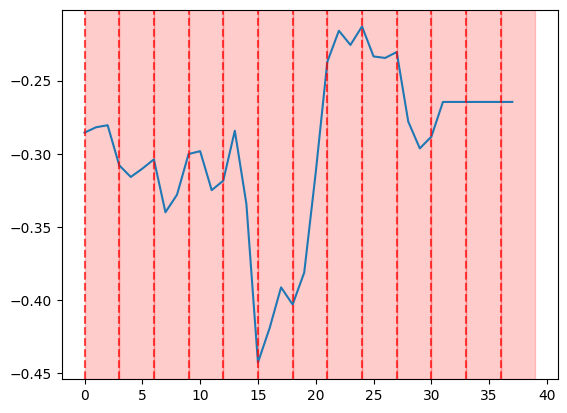

In [18]:
seq_to_plot =  cleaned_df['sequence_id'].unique()[0]
time_feature = cleaned_df[cleaned_df['sequence_id'] == seq_to_plot]['rot_x']

plt.plot(range(len(time_feature)), time_feature)
break_points = [0]

s = 3
k = 3
for i in range(0, len(time_feature), s):
    # if i != s * 3:
    #     continue
    
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.7)
    plt.axvspan(i, i+k, color='r', alpha=0.2)
    # break

In [19]:
class SimpleModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=5, stride=1, padding="same", bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(3),
            nn.Dropout(0.1),
            #
            nn.Conv1d(32, 32, kernel_size=3, stride=1, padding="same", bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.1),
            #
            nn.AdaptiveAvgPool1d(1),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x = self.conv_layer(x)  # x out_dim
        y_pred = self.fc(x)

        return y_pred


dummy_input = torch.rand(64, 15, 35)
dummy_model = SimpleModel(15, len(encoder.classes_))
dummy_model(dummy_input).shape

torch.Size([64, 9])

In [20]:
# FacePlant? aka what the fuck am i doing with my life
n_splits = 4
gkf = GroupKFold(n_splits)
subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])

n_features = features_full_seq.shape[1]
batch_size = 33
n_epochs = 300

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []

test_subjects = []
lgbm_folds_score = []
lgbm_folds_score_train = []
cnn_folds_score = []
cnn_folds_score_train = []
importances = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_full_seq, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    # ---Prepare
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = features_full_seq[train_indices], target_tensor[train_indices] # B x F x T
    X_test, y_test = features_full_seq[test_indices], target_tensor[test_indices]
    
    mean = X_train.mean(dim=(0, 2)).view(1, -1, 1)   # shape (1xFx1)
    std  = X_train.std(dim=(0, 2), unbiased=False).view(1, -1, 1) + 1e-8  # shape (1xFx1)

    # Normalize
    X_train = (X_train - mean) / (std + 1e-14)
    X_test  = (X_test  - mean) / (std + 1e-14)
    
    X_train_arr.append(X_train.cpu().numpy())
    X_test_arr.append(X_test.cpu().numpy())
    y_train_arr.append(y_train.cpu().numpy())
    y_test_arr.append(y_test.cpu().numpy())
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    # ---End prepare
    
    model = SimpleModel(n_features, len(encoder.classes_)).to(device)
    model.train()
    # train_model(model, dataloader_train, n_epochs, True)
    train_model(model, dataloader_train, n_epochs, True, lr=5e-3, weight_decay=3e-4, n_classes=len(encoder.classes_))

    
    model.eval()
    y_pred = torch.argmax(model(X_test), dim=1)
    score_dashboard = evaluate_model(y_pred, y_test, target_gestures_encoded, encoder)
    cnn_folds_score.append(score_dashboard)
    
    y_pred = torch.argmax(model(X_train), dim=1)
    score_dashboard = evaluate_model(y_pred, y_train, target_gestures_encoded, encoder)
    cnn_folds_score_train.append(score_dashboard)
    
    # Train GBM on CNN features
    model_cut_head = model.conv_layer
    model_cut_head.eval()
    
    cnn_features_train = model_cut_head(X_train).view(X_train.shape[0], -1).detach().cpu().numpy() # B x cnn_out_features
    cnn_features_test = model_cut_head(X_test).view(X_test.shape[0], -1).detach().cpu().numpy() # B x cnn_out_features
    
    lgbm_features_train = np.concat([features_summaries[train_indices], cnn_features_train], axis=1)
    lgbm_features_test = np.concat([features_summaries[test_indices], cnn_features_test], axis=1)
    
    lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31)
    lgbm.fit(lgbm_features_train, y_train)
    importances.append(lgbm.feature_importances_)

    y_pred = lgbm.predict(lgbm_features_test)
    score_dashboard = evaluate_model(y_pred, y_test, target_gestures_encoded, encoder)
    lgbm_folds_score.append(score_dashboard)
    
    y_pred = lgbm.predict(lgbm_features_train)
    score_dashboard = evaluate_model(y_pred, y_train, target_gestures_encoded, encoder)
    lgbm_folds_score_train.append(score_dashboard)


------FOLD 1/4------

0 - loss_avg: 1.7845, lr: 0.005000
20 - loss_avg: 1.5192, lr: 0.005000
40 - loss_avg: 1.4777, lr: 0.005000
60 - loss_avg: 1.4320, lr: 0.005000
80 - loss_avg: 1.4225, lr: 0.005000
100 - loss_avg: 1.3922, lr: 0.005000
120 - loss_avg: 1.3546, lr: 0.002500
140 - loss_avg: 1.3411, lr: 0.002500
160 - loss_avg: 1.3485, lr: 0.002500
180 - loss_avg: 1.3064, lr: 0.001250
200 - loss_avg: 1.3077, lr: 0.001250
220 - loss_avg: 1.2578, lr: 0.000625
240 - loss_avg: 1.2431, lr: 0.000625
260 - loss_avg: 1.2742, lr: 0.000625
280 - loss_avg: 1.2131, lr: 0.000313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20655
[LightGBM] [Info] Number of data points in the train set: 5845, number of used features: 81
[LightGBM] [Info] Start training from score -2.512135
[LightGBM] [Info] Start training from score -2.516363
[LightGBM] [Info] Start trainin

/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



------FOLD 2/4------

0 - loss_avg: 1.7724, lr: 0.005000
20 - loss_avg: 1.5223, lr: 0.005000
40 - loss_avg: 1.4740, lr: 0.005000
60 - loss_avg: 1.4740, lr: 0.005000
80 - loss_avg: 1.4276, lr: 0.005000
100 - loss_avg: 1.4080, lr: 0.005000
120 - loss_avg: 1.3908, lr: 0.005000
140 - loss_avg: 1.3728, lr: 0.002500
160 - loss_avg: 1.3517, lr: 0.002500
180 - loss_avg: 1.3157, lr: 0.001250
200 - loss_avg: 1.3283, lr: 0.001250
220 - loss_avg: 1.3280, lr: 0.001250
240 - loss_avg: 1.2797, lr: 0.000625
260 - loss_avg: 1.2606, lr: 0.000625
280 - loss_avg: 1.2738, lr: 0.000313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20655
[LightGBM] [Info] Number of data points in the train set: 5854, number of used features: 81
[LightGBM] [Info] Start training from score -2.520022
[LightGBM] [Info] Start training from score -2.517901
[LightGBM] [Info] Start trainin

/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



------FOLD 3/4------

0 - loss_avg: 1.8172, lr: 0.005000
20 - loss_avg: 1.5690, lr: 0.005000
40 - loss_avg: 1.4862, lr: 0.005000
60 - loss_avg: 1.4612, lr: 0.005000
80 - loss_avg: 1.4306, lr: 0.005000
100 - loss_avg: 1.4420, lr: 0.005000
120 - loss_avg: 1.4625, lr: 0.002500
140 - loss_avg: 1.4056, lr: 0.002500
160 - loss_avg: 1.2766, lr: 0.001250
180 - loss_avg: 1.3499, lr: 0.001250
200 - loss_avg: 1.2931, lr: 0.000625
220 - loss_avg: 1.3047, lr: 0.000625
240 - loss_avg: 1.2847, lr: 0.000313
260 - loss_avg: 1.3335, lr: 0.000313
280 - loss_avg: 1.2617, lr: 0.000156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20655
[LightGBM] [Info] Number of data points in the train set: 5833, number of used features: 81
[LightGBM] [Info] Start training from score -2.520684
[LightGBM] [Info] Start training from score -2.520684
[LightGBM] [Info] Start trainin

/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



------FOLD 4/4------

0 - loss_avg: 1.7998, lr: 0.005000
20 - loss_avg: 1.5375, lr: 0.005000
40 - loss_avg: 1.5052, lr: 0.005000
60 - loss_avg: 1.4834, lr: 0.005000
80 - loss_avg: 1.5048, lr: 0.005000
100 - loss_avg: 1.4607, lr: 0.005000
120 - loss_avg: 1.4386, lr: 0.005000
140 - loss_avg: 1.3794, lr: 0.002500
160 - loss_avg: 1.3529, lr: 0.002500
180 - loss_avg: 1.3420, lr: 0.001250
200 - loss_avg: 1.3151, lr: 0.000625
220 - loss_avg: 1.3335, lr: 0.000625
240 - loss_avg: 1.2971, lr: 0.000313
260 - loss_avg: 1.2634, lr: 0.000313
280 - loss_avg: 1.2956, lr: 0.000156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20655
[LightGBM] [Info] Number of data points in the train set: 5838, number of used features: 81
[LightGBM] [Info] Start training from score -2.519411
[LightGBM] [Info] Start training from score -2.523675
[LightGBM] [Info] Start trainin

/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM FOLD SCORE
test - macro: 0.476, binary: 0.935, competition: 0.705
train - macro: 1.000, binary: 1.000, competition: 1.000


,precision,recall,f1-score,support
Above ear - pull hair,0.495596,0.447129,0.469036,157.000000
Cheek - pinch skin,0.352629,0.323542,0.337433,156.750000
Eyebrow - pull hair,0.316291,0.300952,0.306524,158.500000
Eyelash - pull hair,0.462365,0.449143,0.455048,157.500000
Forehead - pull hairline,0.473162,0.472124,0.471852,158.250000
Forehead - scratch,0.581423,0.586260,0.582001,157.250000
Neck - pinch skin,0.359645,0.338825,0.345873,156.750000
Neck - scratch,0.437653,0.414585,0.425350,155.500000
Non-target,0.856909,0.923858,0.888894,690.000000
accuracy,0.596323,0.596323,0.596323,0.596323


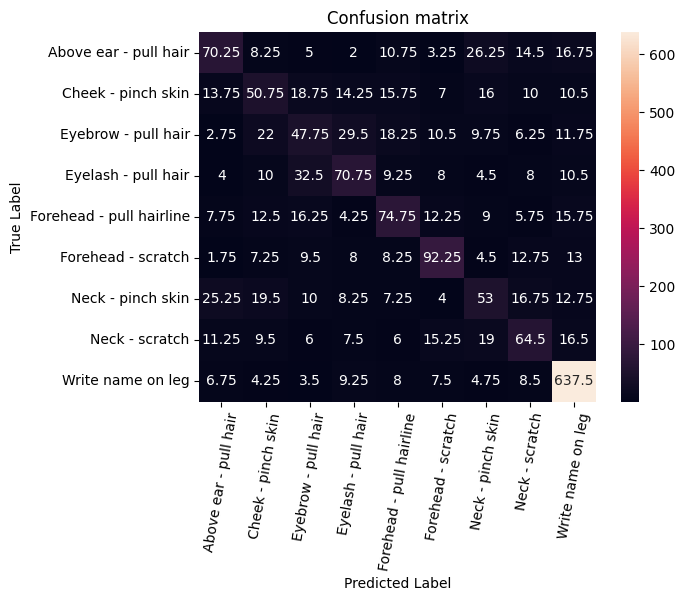

In [23]:
print("LGBM FOLD SCORE")
fold_scores = lgbm_folds_score
fold = get_avg_fold(lgbm_folds_score)
fold_train = get_avg_fold(lgbm_folds_score_train)

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

macro_train = fold_train["f1_macro"]
binary_train = fold_train["f1_binary"]
competition_eval_train = fold_train["competition_evaluation"]
cm_train = fold_train['confusion_matrix']

print(f'test - macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')
print(f'train - macro: {macro_train:.3f}, binary: {binary_train:.3f}, competition: {competition_eval_train:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

CNN FOLD SCORE
test - macro: 0.458, binary: 0.935, competition: 0.696
train - macro: 0.665, binary: 0.978, competition: 0.821


,precision,recall,f1-score,support
Above ear - pull hair,0.474176,0.443768,0.457222,157.000000
Cheek - pinch skin,0.341992,0.299605,0.318134,156.750000
Eyebrow - pull hair,0.320449,0.301022,0.308051,158.500000
Eyelash - pull hair,0.403687,0.473008,0.434122,157.500000
Forehead - pull hairline,0.531085,0.410584,0.460693,158.250000
Forehead - scratch,0.517856,0.670423,0.583377,157.250000
Neck - pinch skin,0.329934,0.259043,0.288671,156.750000
Neck - scratch,0.444483,0.338869,0.382372,155.500000
Non-target,0.851866,0.931507,0.889843,690.000000
accuracy,0.588117,0.588117,0.588117,0.588117


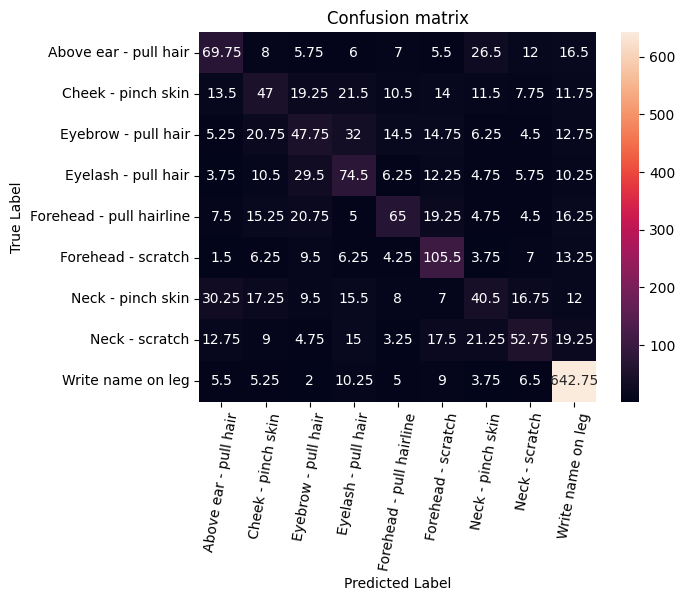

In [24]:
print("CNN FOLD SCORE")
fold_scores = cnn_folds_score
fold = get_avg_fold(cnn_folds_score)
fold_train = get_avg_fold(cnn_folds_score_train)

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

macro_train = fold_train["f1_macro"]
binary_train = fold_train["f1_binary"]
competition_eval_train = fold_train["competition_evaluation"]
cm_train = fold_train['confusion_matrix']

print(f'test - macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')
print(f'train - macro: {macro_train:.3f}, binary: {binary_train:.3f}, competition: {competition_eval_train:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

['rotvec_x_mean', 'rotvec_x_std', 'rotvec_y_mean', 'rotvec_y_std', 'rotvec_z_mean', 'rotvec_z_std', 'rot_angle_mean', 'rot_angle_std', 'angular_vel_x_mean', 'angular_vel_x_std', 'angular_vel_x_min', 'angular_vel_x_max', 'angular_vel_y_mean', 'angular_vel_y_std', 'angular_vel_y_min', 'angular_vel_y_max', 'angular_vel_z_mean', 'angular_vel_z_std', 'angular_vel_z_min', 'angular_vel_z_max', 'angular_speed_mean', 'angular_speed_std', 'angular_speed_max', 'acc_x_mean', 'acc_x_std', 'acc_y_mean', 'acc_y_std', 'acc_z_mean', 'acc_z_std', 'acc_mag_mean', 'acc_mag_std', 'jerk_acc_x_mean', 'jerk_acc_x_std', 'jerk_acc_x_min', 'jerk_acc_x_max', 'jerk_acc_y_mean', 'jerk_acc_y_std', 'jerk_acc_y_min', 'jerk_acc_y_max', 'jerk_acc_z_mean', 'jerk_acc_z_std', 'jerk_acc_z_min', 'jerk_acc_z_max', 'fft_linear_acc_x_mean', 'fft_linear_acc_x_std', 'fft_linear_acc_y_mean', 'fft_linear_acc_y_std', 'fft_linear_acc_z_mean', 'fft_linear_acc_z_std', 'cnn_0', 'cnn_1', 'cnn_2', 'cnn_3', 'cnn_4', 'cnn_5', 'cnn_6', 'cnn_

,feature,importance
18,angular_vel_z_min,906.75
10,angular_vel_x_min,865.50
11,angular_vel_x_max,860.00
19,angular_vel_z_max,842.25
13,angular_vel_y_std,799.25
9,angular_vel_x_std,798.50
14,angular_vel_y_min,792.25
15,angular_vel_y_max,770.75
20,angular_speed_mean,765.75
17,angular_vel_z_std,705.75


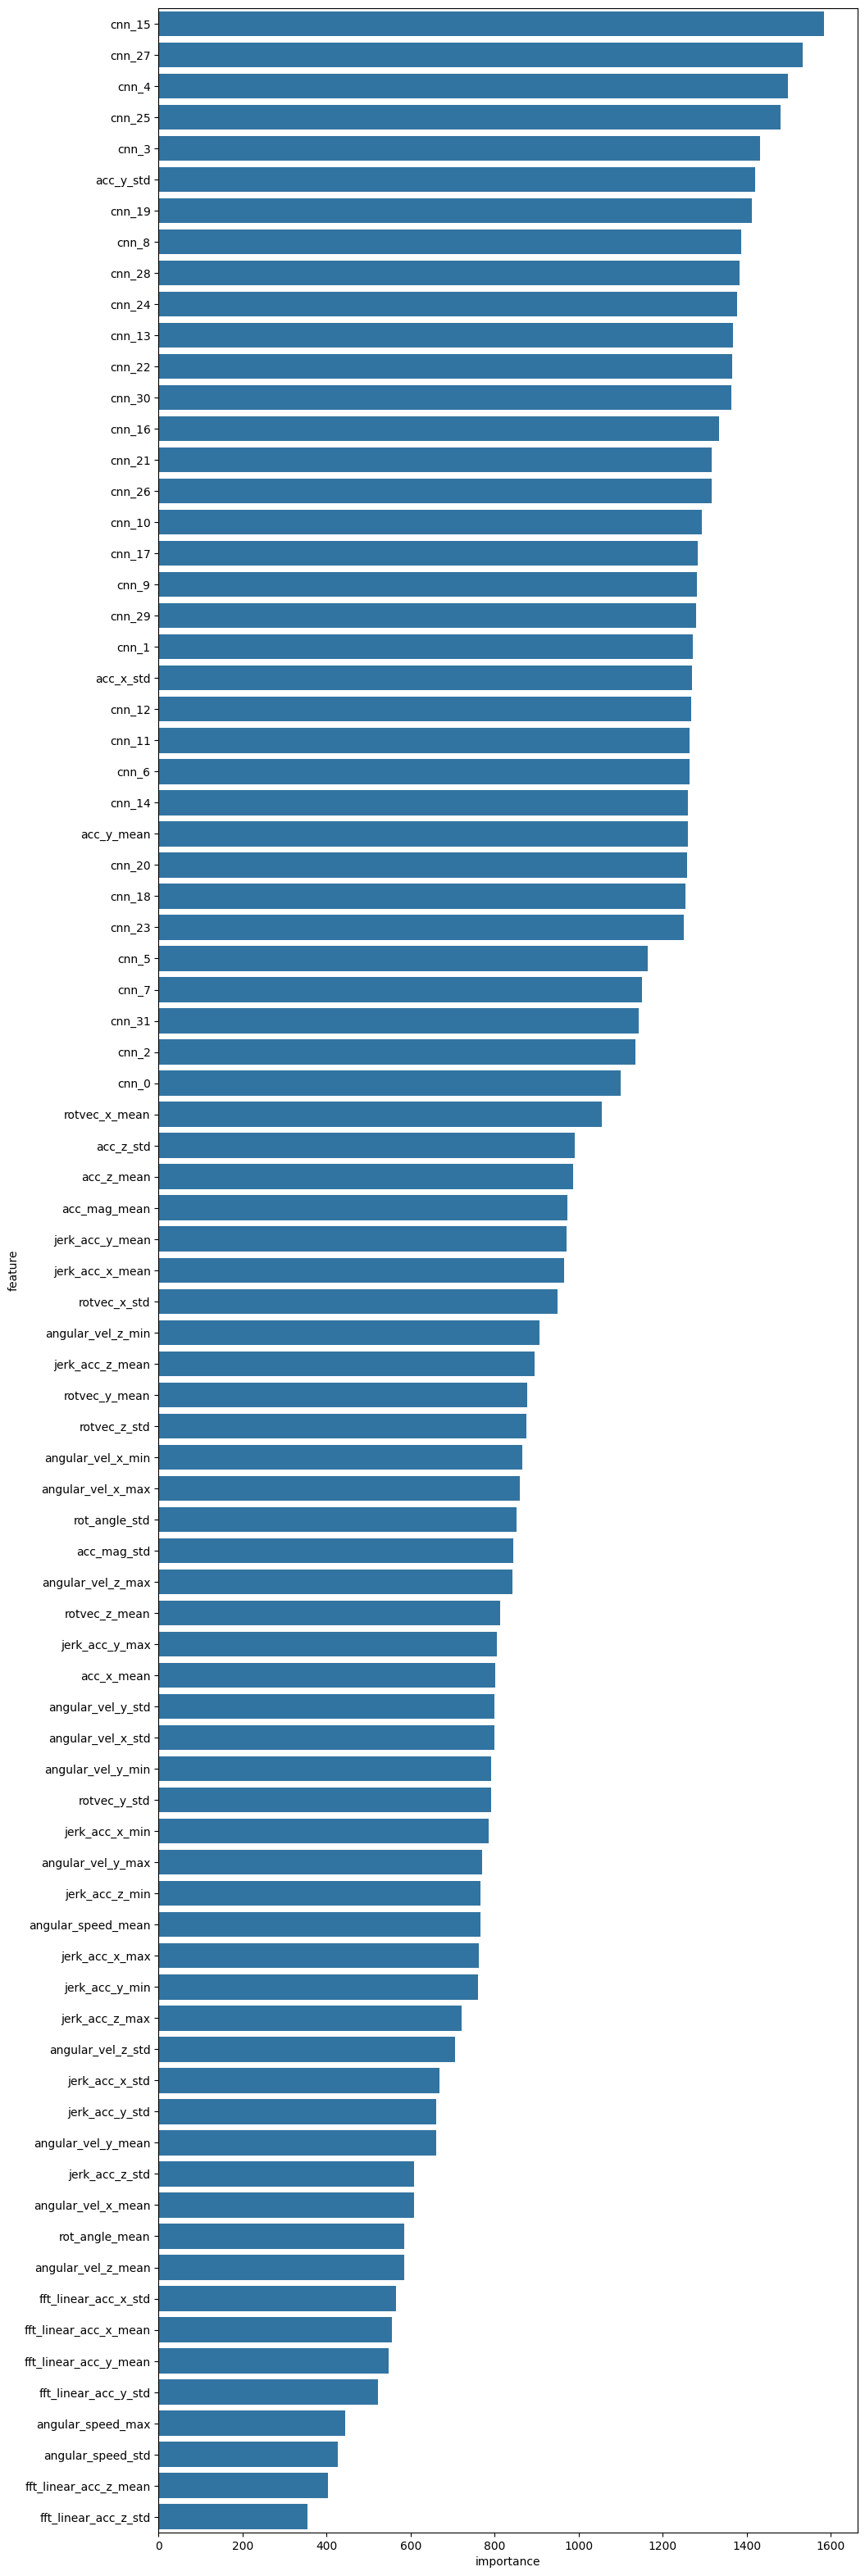

In [51]:
avg_importances =np.mean(importances, axis=0)

statistical_feature_names = filtered_df.drop(columns=["gesture_first", "subject_first"]).columns.tolist()
cnn_feature_names = [f"cnn_{i}" for i in range(avg_importances.shape[0] - len(statistical_feature_names))]
col_names = statistical_feature_names + cnn_feature_names
print(col_names)

importance_df = pd.DataFrame({
    'feature': col_names,
    'importance': avg_importances,
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(11, 40))
sns.barplot(importance_df, x='importance', y='feature')
plt.title("")

importance_df[importance_df['feature'].str.contains("angular")]

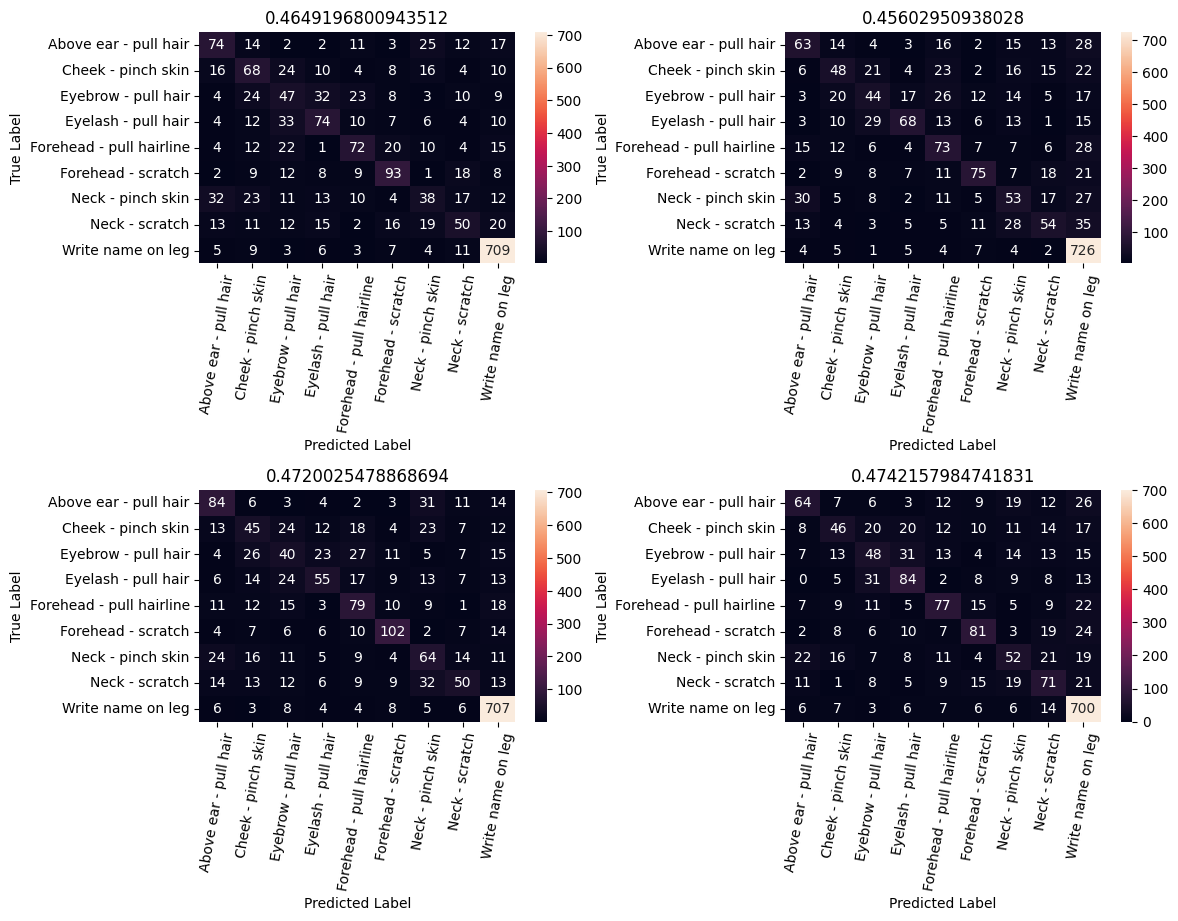

In [ ]:
plt.figure(figsize=(12, 12))
for i, fold in enumerate(lgbm_folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

([<matplotlib.axis.XTick at 0x74033cab0ef0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

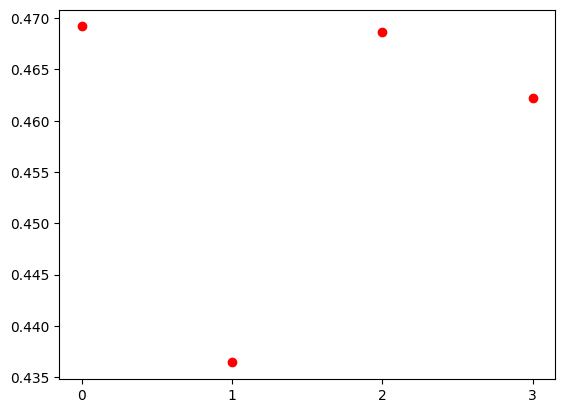

In [ ]:
macros = [f["f1_macro"] for f in lgbm_folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

# bad_idx = 2
# good_idx = 4

# print(f'good subjects: {test_subjects[good_idx]}')
# print(f'bad subjects: {test_subjects[bad_idx]}')

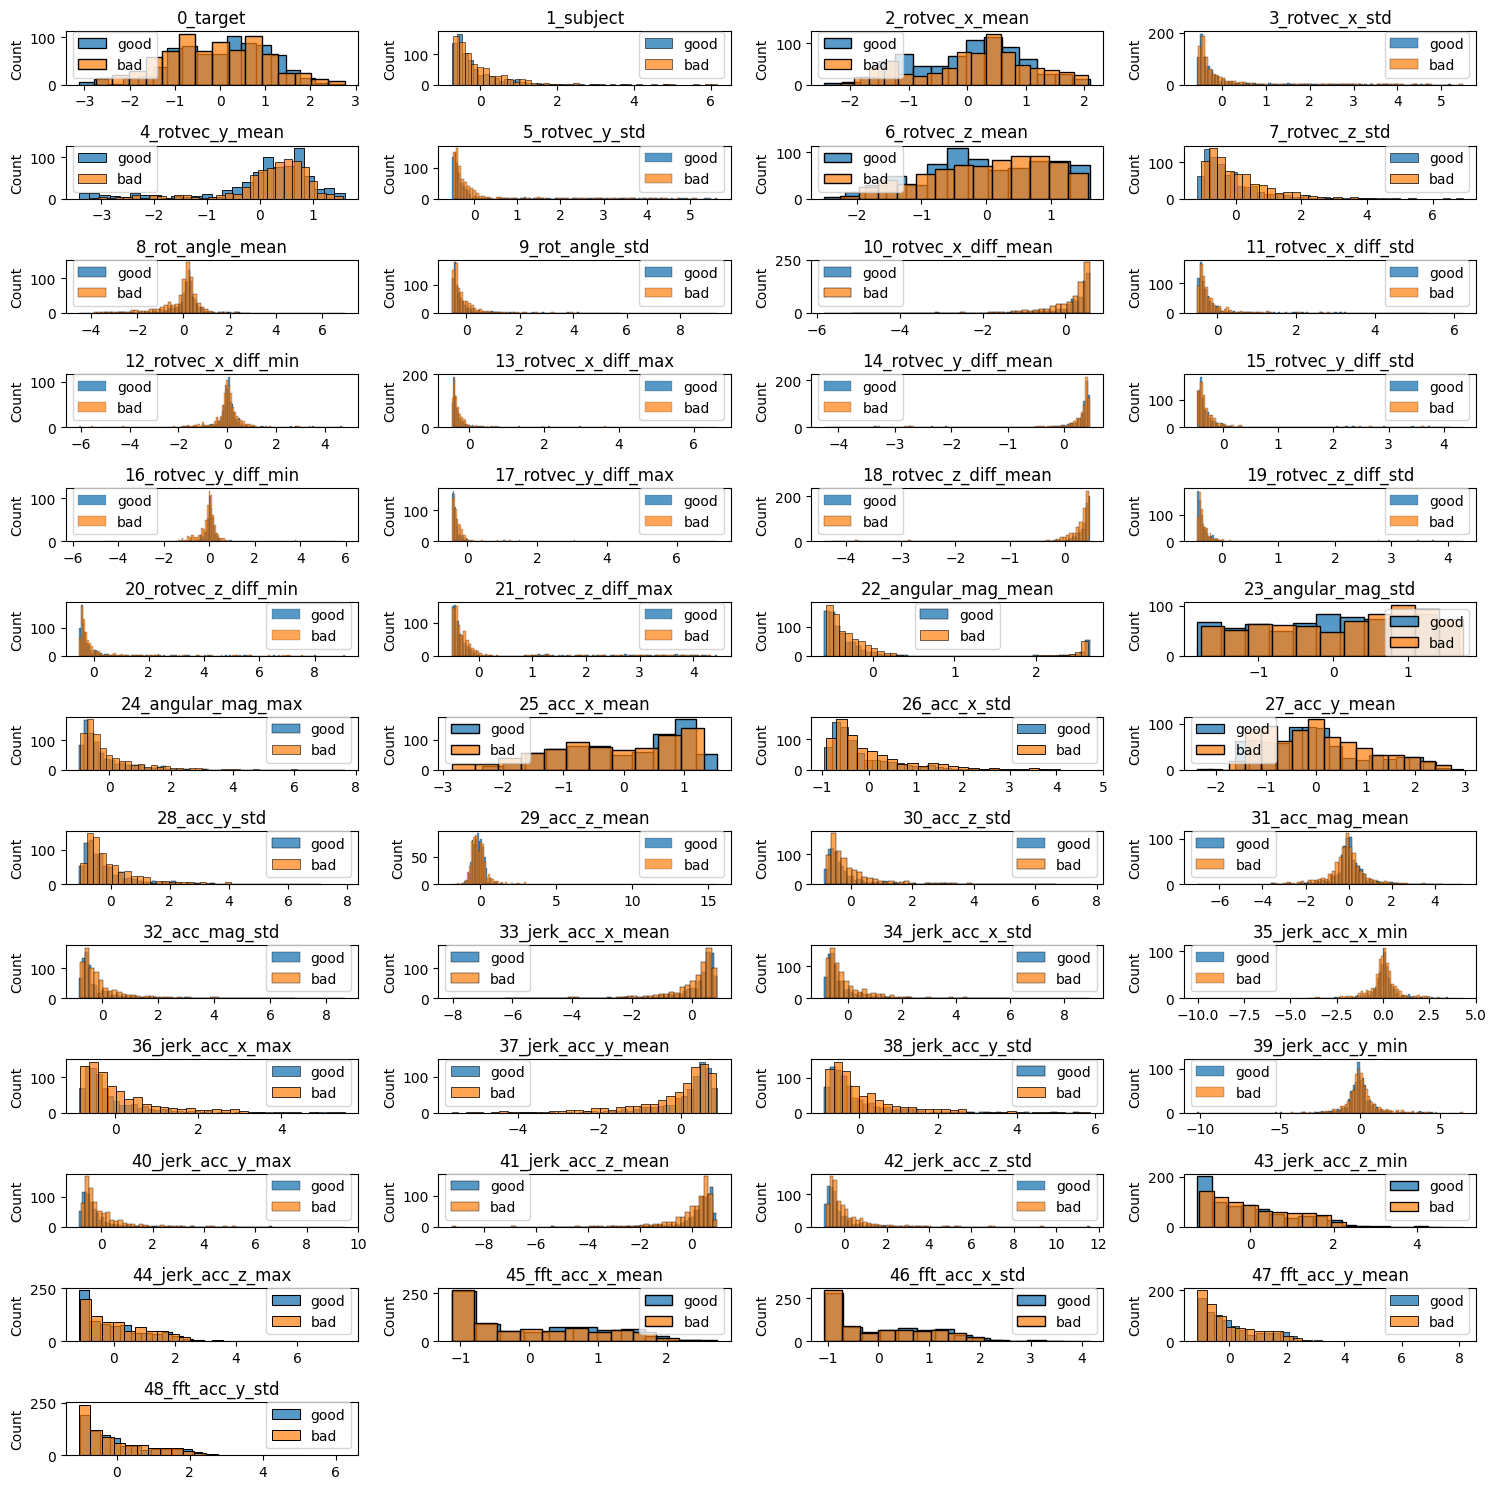

In [50]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

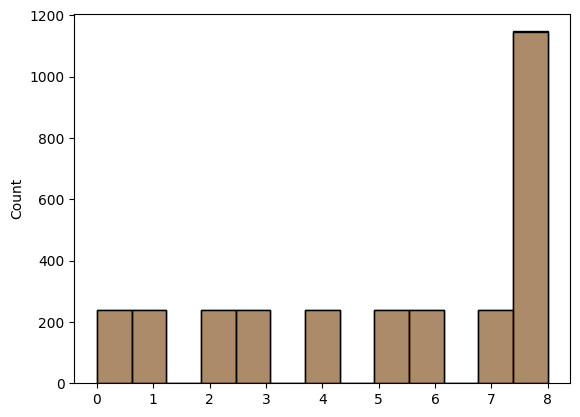

In [53]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
